In [1]:
import toml
import joblib
import random
import seaborn as sns
import matplotlib.pyplot as plt
from kornia.geometry.transform import warp_image_tps, get_tps_transform, scale, resize
from toolz import dissoc, keyfilter
from torch.utils.data import DataLoader
from aging.size_norm.data import CurriculumPipeline, AugmentationParams, TrainingPaths, SizeNormDataset
from aging.size_norm.data import *

In [2]:
config = toml.load('/n/groups/datta/win/longtogeny/size_norm/models/freeze_decoder_00/stage_07/2243dff0-f861-4c66-a57c-494243ddcf09/config.toml')
config["augmentation"]["rng"] = random.Random(config["augmentation"]["seed"])
aug_params = AugmentationParams(**dissoc(config['augmentation'], 'seed'))

In [3]:
paths = keyfilter(lambda k: k in ['training', 'wall_noise', 'validation', 'age_validation'], config['paths'])
paths = TrainingPaths(**paths)

In [4]:
data = SizeNormDataset(paths)

In [5]:
class CurriculumPipeline:
    def __init__(
        self, rate: float, params: AugmentationParams, block_transitions: list | tuple
    ):
        """block_transitions: list of step numbers at which to transition to the next block"""
        self.transitions = sorted(block_transitions)
        self.rng = params.rng
        self.pipeline = [
            ( CurriculumAugmentation(
                    # tps_sampler_factory(params.tps_sampler_path),
                    elastic_transform_factory(params.tps_sampler_path),
                    params.tps_warp_prob,
                    rate,
                    params,
                ), 3,),
            (CurriculumAugmentation(identity_fun, 1, 1, params), 0),
            # ( CurriculumAugmentation( white_noise, params.white_noise_prob, rate, params), 1,),
            # (CurriculumAugmentation(scale_fun, params.scale_prob, rate, params), 1),
            # ( CurriculumAugmentation( rotation_fun, params.rotation_prob, rate, params), 1,),
            # ( CurriculumAugmentation( translate_fun, params.translation_prob, rate, params), 1,),
            # (CurriculumAugmentation(shear_fun, params.shear_prob, rate, params), 1), ( CurriculumAugmentation( height_scale_fun, params.height_scale_prob, rate, params), 1,),
            # (CurriculumAugmentation(flip_fun, params.flip_prob, rate, params), 1),
            # ( CurriculumAugmentation( elastic_fun, params.random_elastic_prob, rate, params), 2,),
            # ( CurriculumAugmentation( zoom_unzoom, params.zoom_unzoom_prob, rate, params), 2,),
            # ( CurriculumAugmentation( wall_noise_factory(params.wall_noise_path), params.wall_reflection_prob, rate, params,), 2,),
            # ( CurriculumAugmentation( white_noise, params.white_noise_prob, rate, params), 1,),
            # ( CurriculumAugmentation( scaled_white_noise, params.scaled_white_noise_prob, rate, params), 1,),
            # ( CurriculumAugmentation( min_height_thresholding_fun, params.threshold_prob, rate, params), 2,),
            # ( CurriculumAugmentation( max_height_thresholding_fun, params.threshold_prob, rate, params), 2,),
            # ( CurriculumAugmentation( augmentation_clean, params.clean_prob, rate, params), 2,),
            # ( CurriculumAugmentation( height_offset_fun, params.height_offset_prob, rate, params), 2,),
        ]

    def __call__(self, data: torch.Tensor, step_num: int):
        for func, block_num in self.pipeline:
            block_frac = np.array([max(step_num, 0) - x for x in self.transitions])
            block = sum(block_frac > 0)
            # allow all augmentations during validation by specifying step_num=-1
            if block >= block_num or step_num == -1:
                data = func(data, self.rng, step_num)
        return normalize(data)



In [6]:
aug_fun = CurriculumPipeline(1e-4, aug_params, [0, 0, 0])

In [8]:
data_loader = DataLoader(data, batch_size=16, shuffle=False, num_workers=1)
for frames, target in data_loader:
    aug_d = aug_fun(frames, step_num=-1)
    break

16
torch.Size([16, 2])
torch.Size([16, 2, 9, 9])
torch.Size([16, 1, 5, 8])


In [9]:
frames.shape

torch.Size([16, 1, 80, 80])

In [10]:
def plot_image(frames, aug_frames, index):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(frames[index, 0])
    ax[1].imshow(aug_frames[index, 0])
    plt.show()

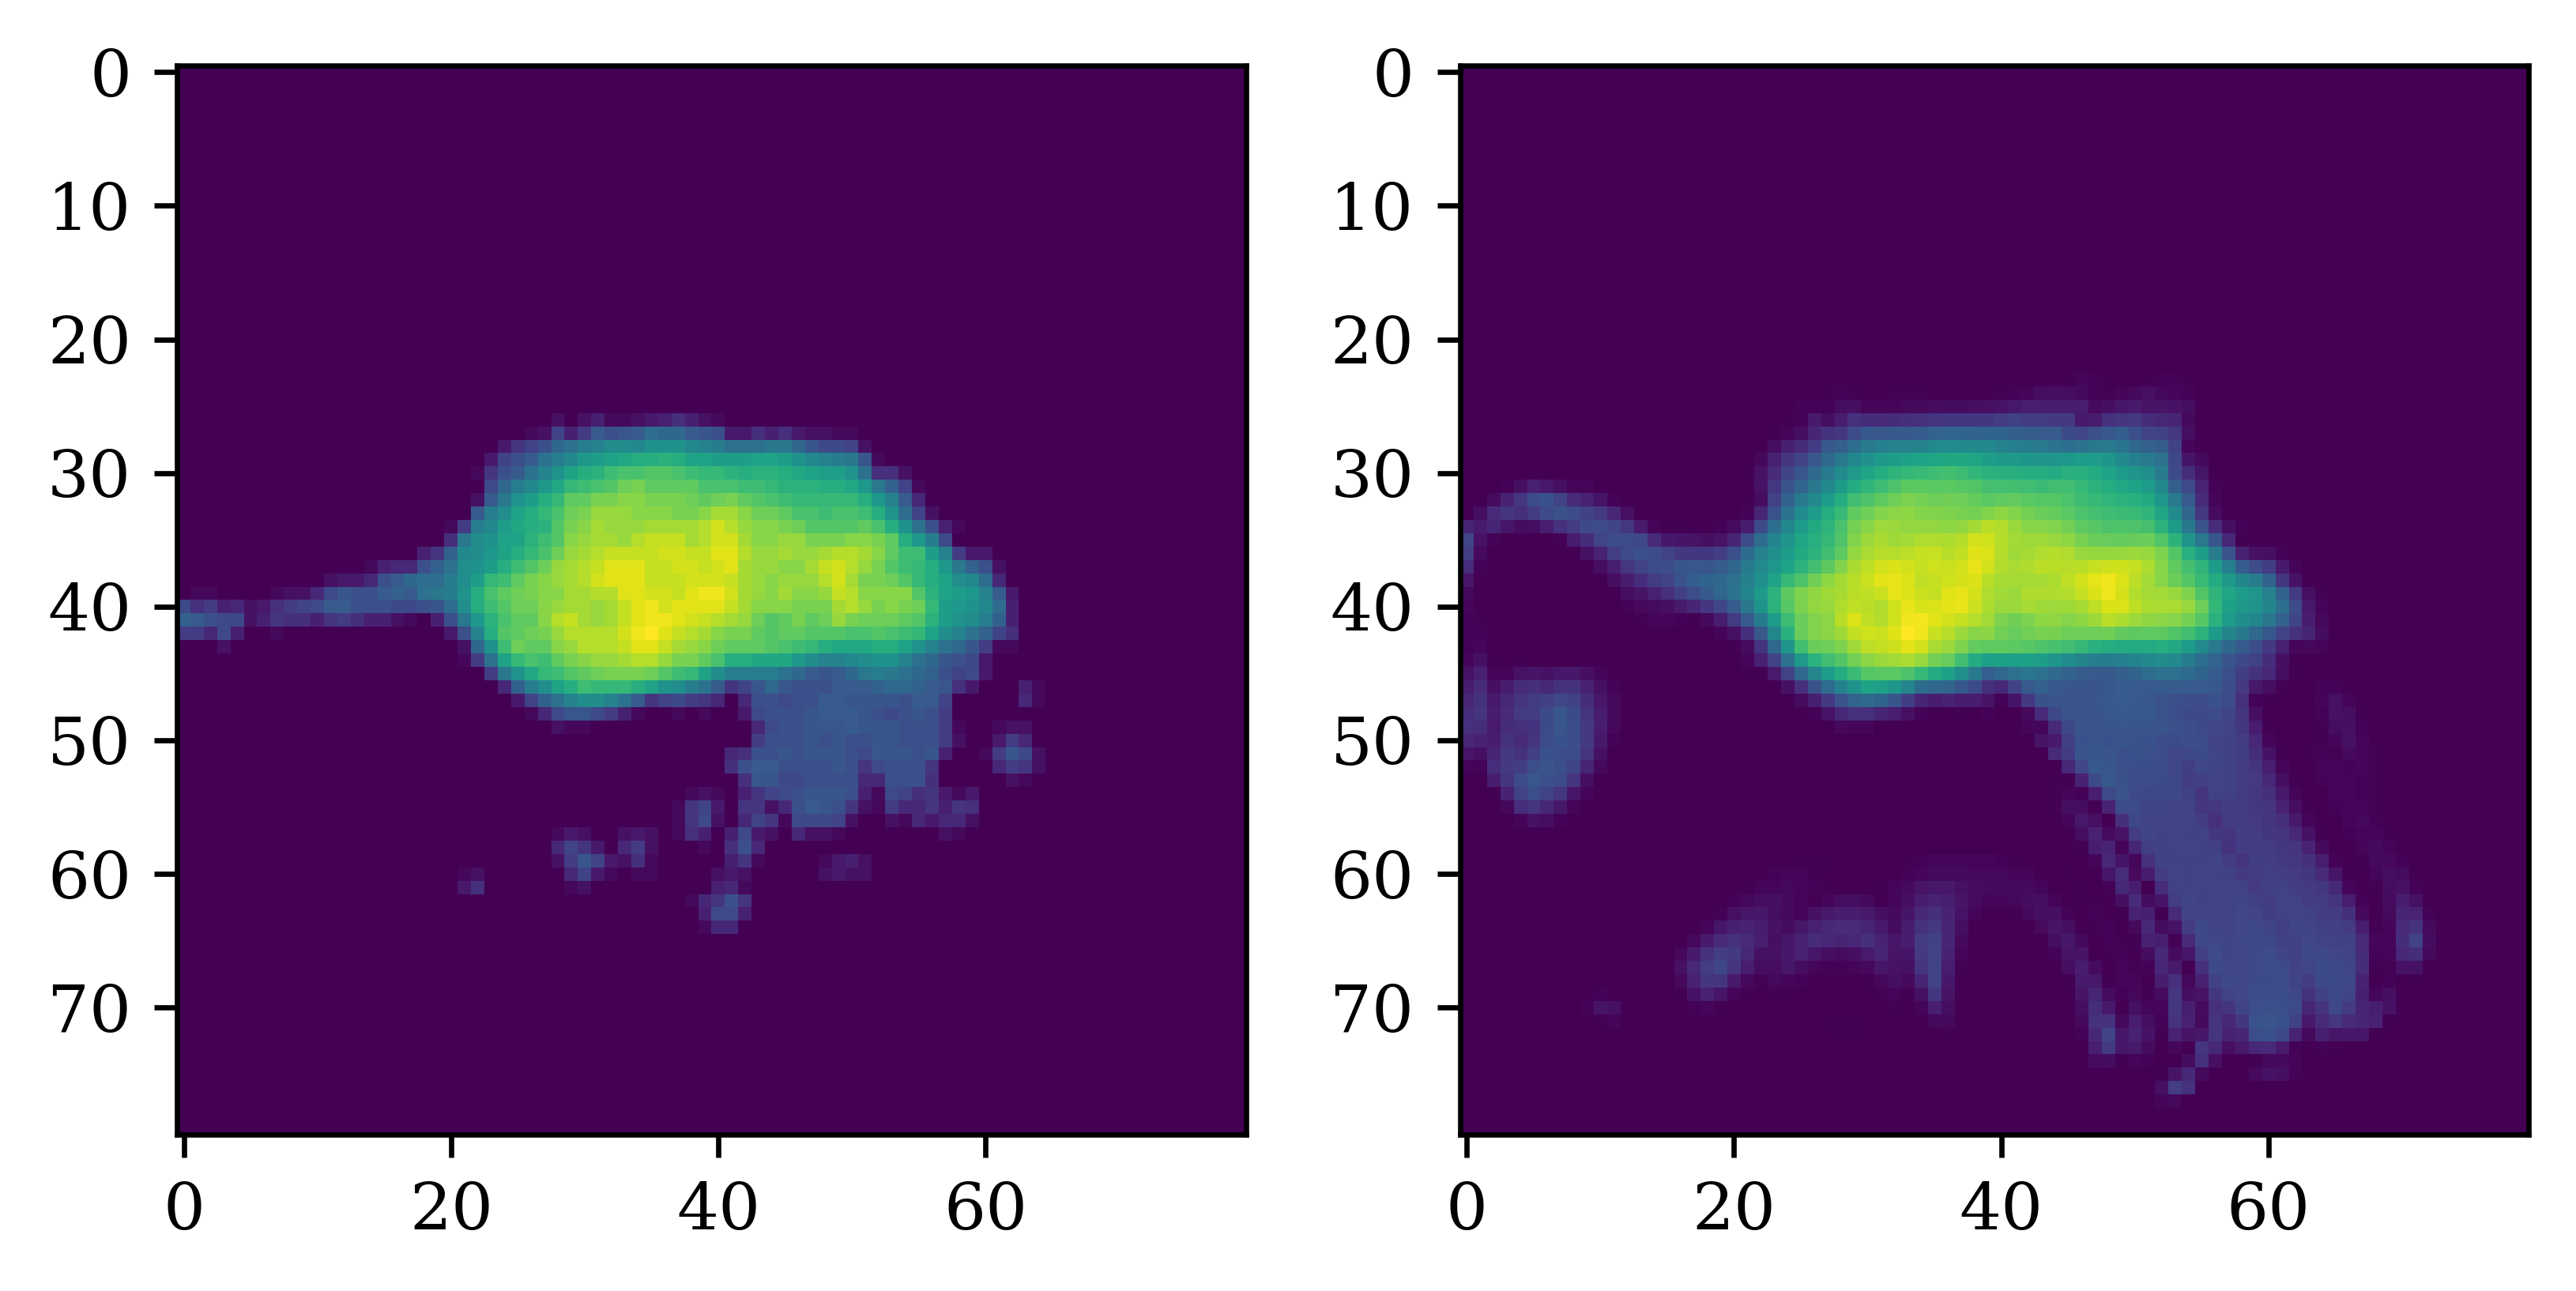

In [15]:
plot_image(frames, aug_d, 3)

In [16]:
def age_dependent_tps_xform(frames, parameters: dict, random_state: random.Random):
    samples = [
        sample_size_changes(parameters, random_state) for _ in range(len(frames))
    ]
    tps_vector, height, scale_params = zip(*samples)
    print(type(tps_vector), len(tps_vector))
    print(torch.stack(tps_vector).shape)
    tps_vector = torch.transpose(torch.stack(tps_vector), 1, 3).to(frames.device)

    grid = make_grid(tps_vector.shape[1], len(frames), device=frames.device)

    kernel, affine = get_tps_transform(
        grid + tps_vector.reshape(len(frames), -1, 2), grid
    )
    scaled_frames = scale(frames, torch.cat(scale_params, dim=0).to(frames.device))
    transformed_frames = warp_image_tps(
        scaled_frames,
        grid.to(frames.device),
        kernel.to(frames.device),
        affine.to(frames.device),
    )

    height_intermediate = resize(
        torch.stack(height).unsqueeze(1).to(frames.device), frames.shape[-2:]
    )

    out = transformed_frames * height_intermediate
    return out, samples, grid, tps_vector


def tps_sampler_factory(tps_sampler_path):
    tps_sampling_params = joblib.load(tps_sampler_path)

    def tps_sampler(data, params: AugmentationParams):
        return age_dependent_tps_xform(data, tps_sampling_params, params.rng)

    return tps_sampler

In [17]:
factory = tps_sampler_factory(aug_params.tps_sampler_path)

In [18]:
aug_params.rng = random.Random(0)
aug_frames, samples, grid, tps_vector = factory(frames, aug_params)

<class 'tuple'> 16
torch.Size([16, 2, 10, 10])


In [88]:
kernel, affine = get_tps_transform(
    grid + torch.clamp(tps_vector.reshape(len(frames), -1, 2), min=-0.08, max=0.08), grid, 
)

transformed_frames = warp_image_tps(
    frames,
    grid.to(frames.device),
    kernel.to(frames.device),
    affine.to(frames.device),
)

In [84]:
tps_vector.shape

torch.Size([16, 6, 6, 2])

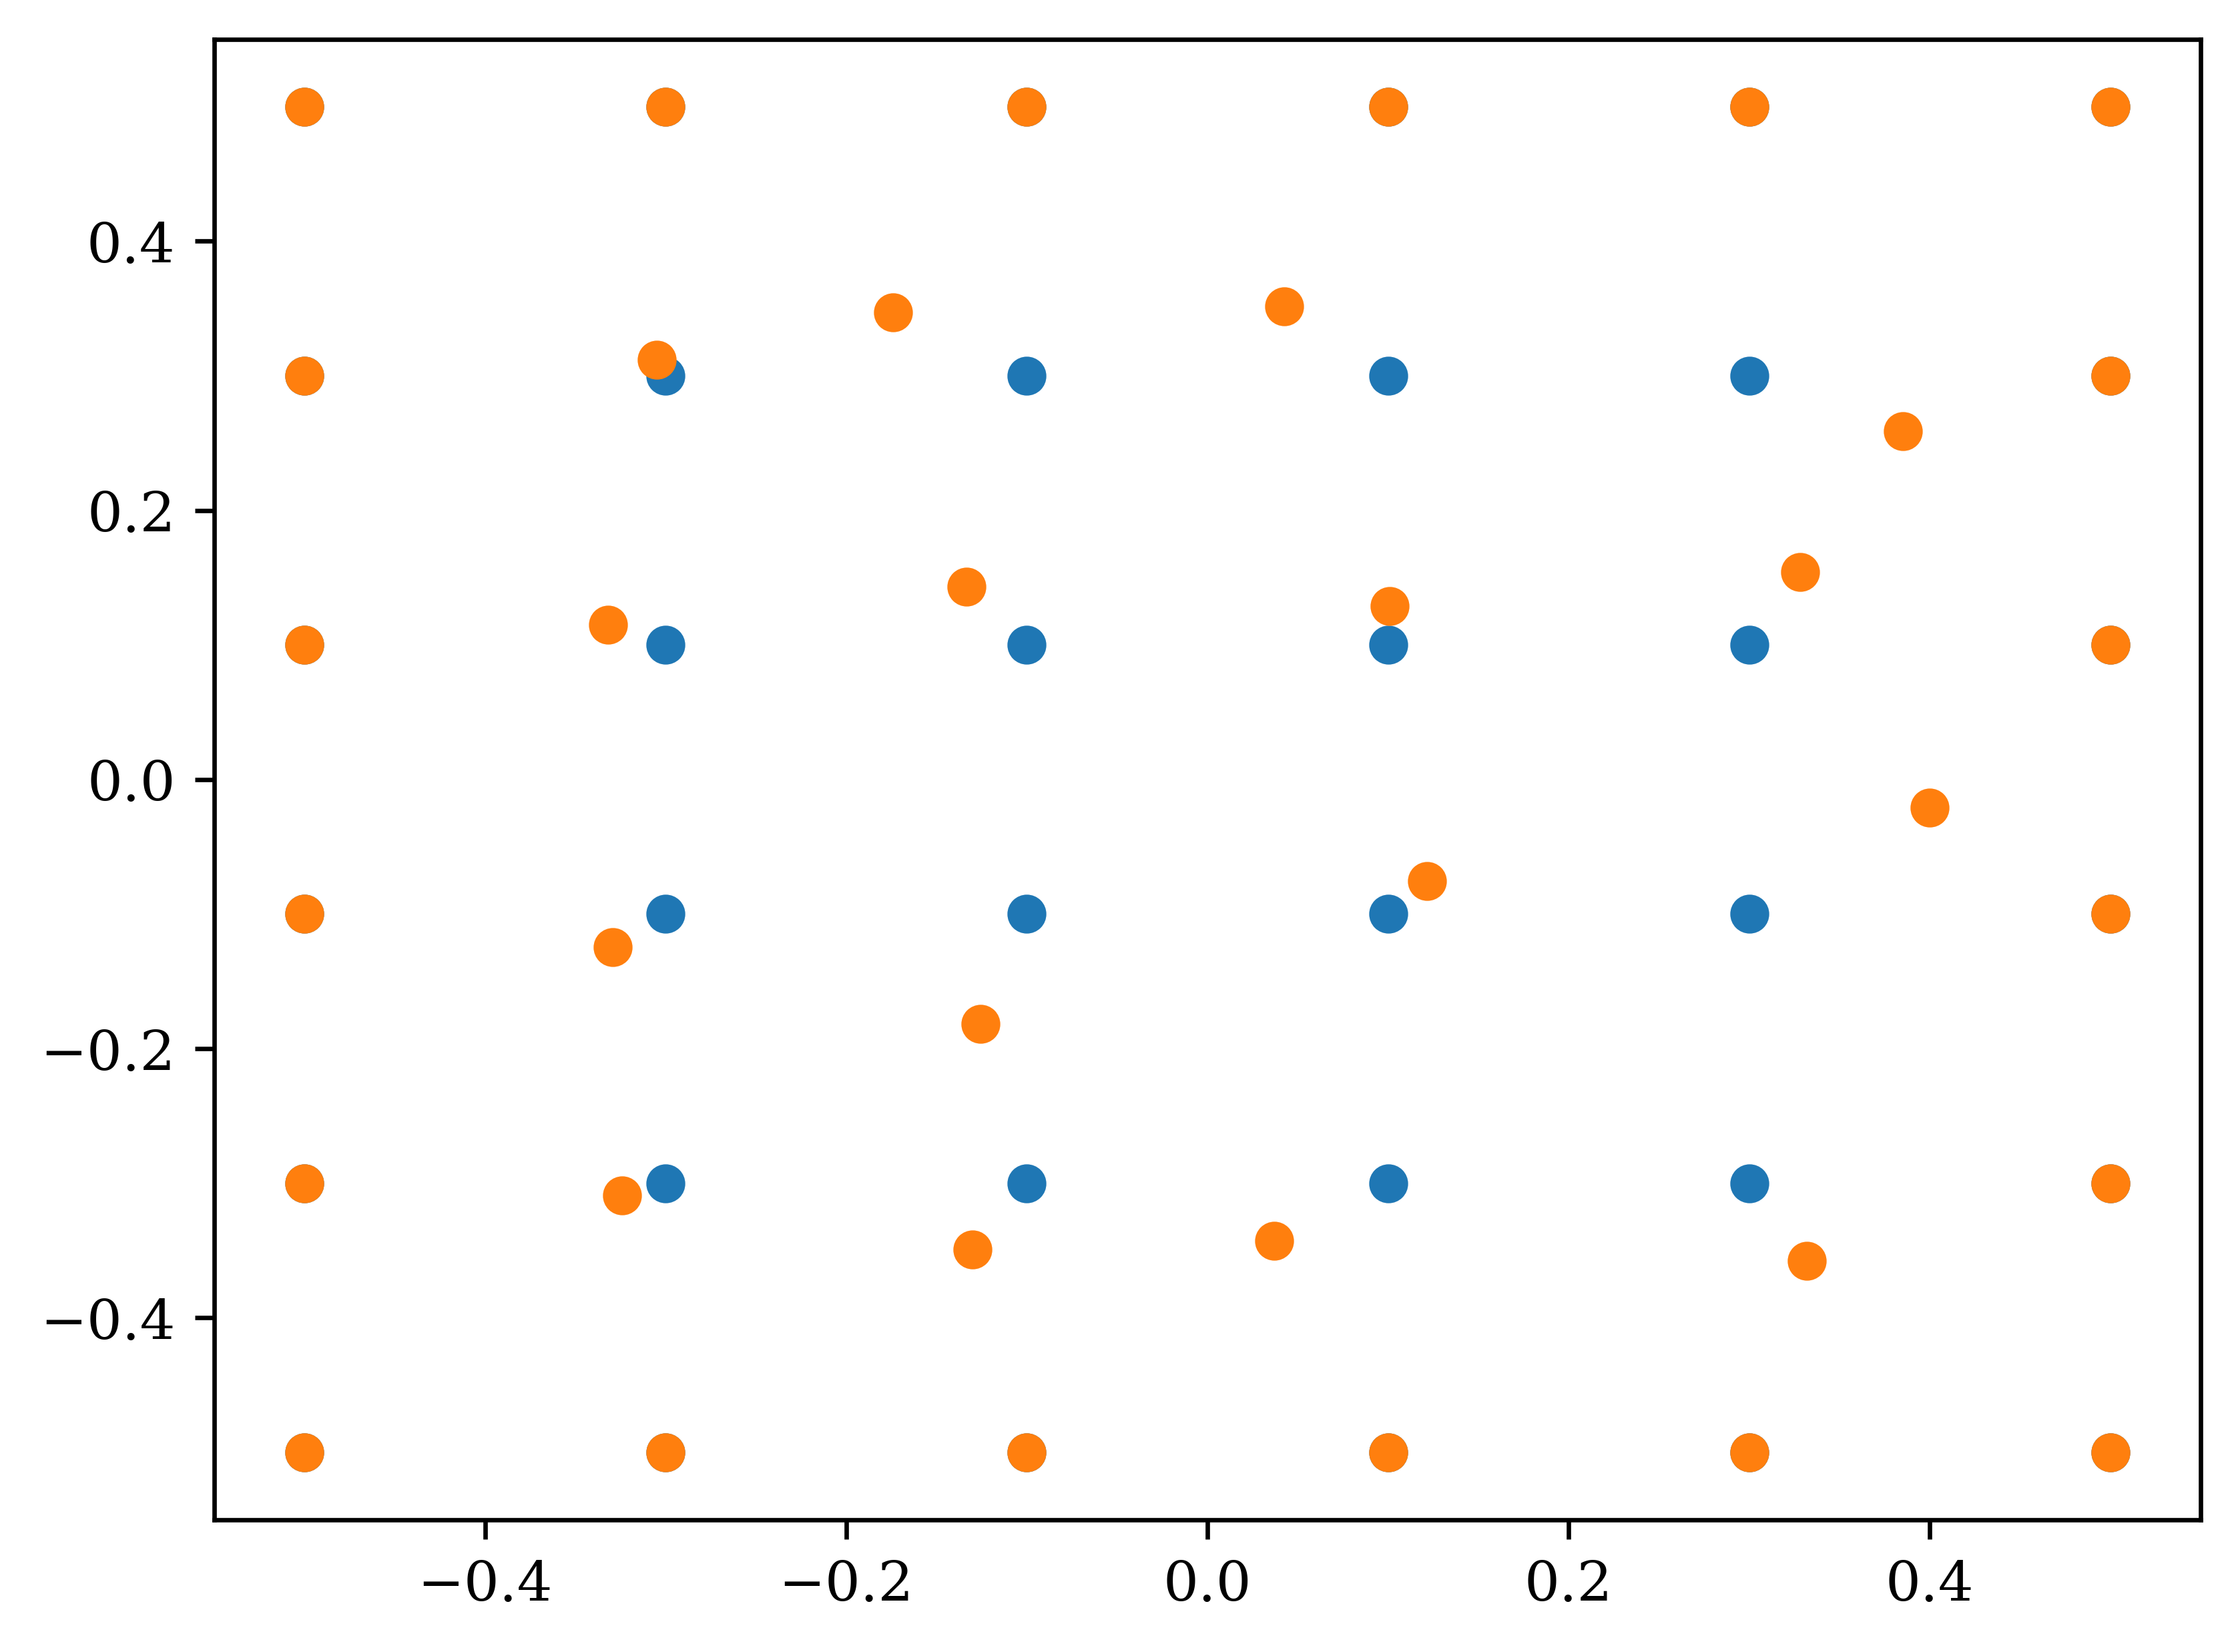

In [86]:
plt.scatter(grid[0, :, 0], grid[0, :, 1])
tmp = grid + torch.clamp(tps_vector.reshape(len(frames), -1, 2), min=-0.1, max=0.1)
plt.scatter(tmp[0, :, 0], tmp[0, :, 1])

In [79]:
# plt.imshow(aug_frames[0, 0])

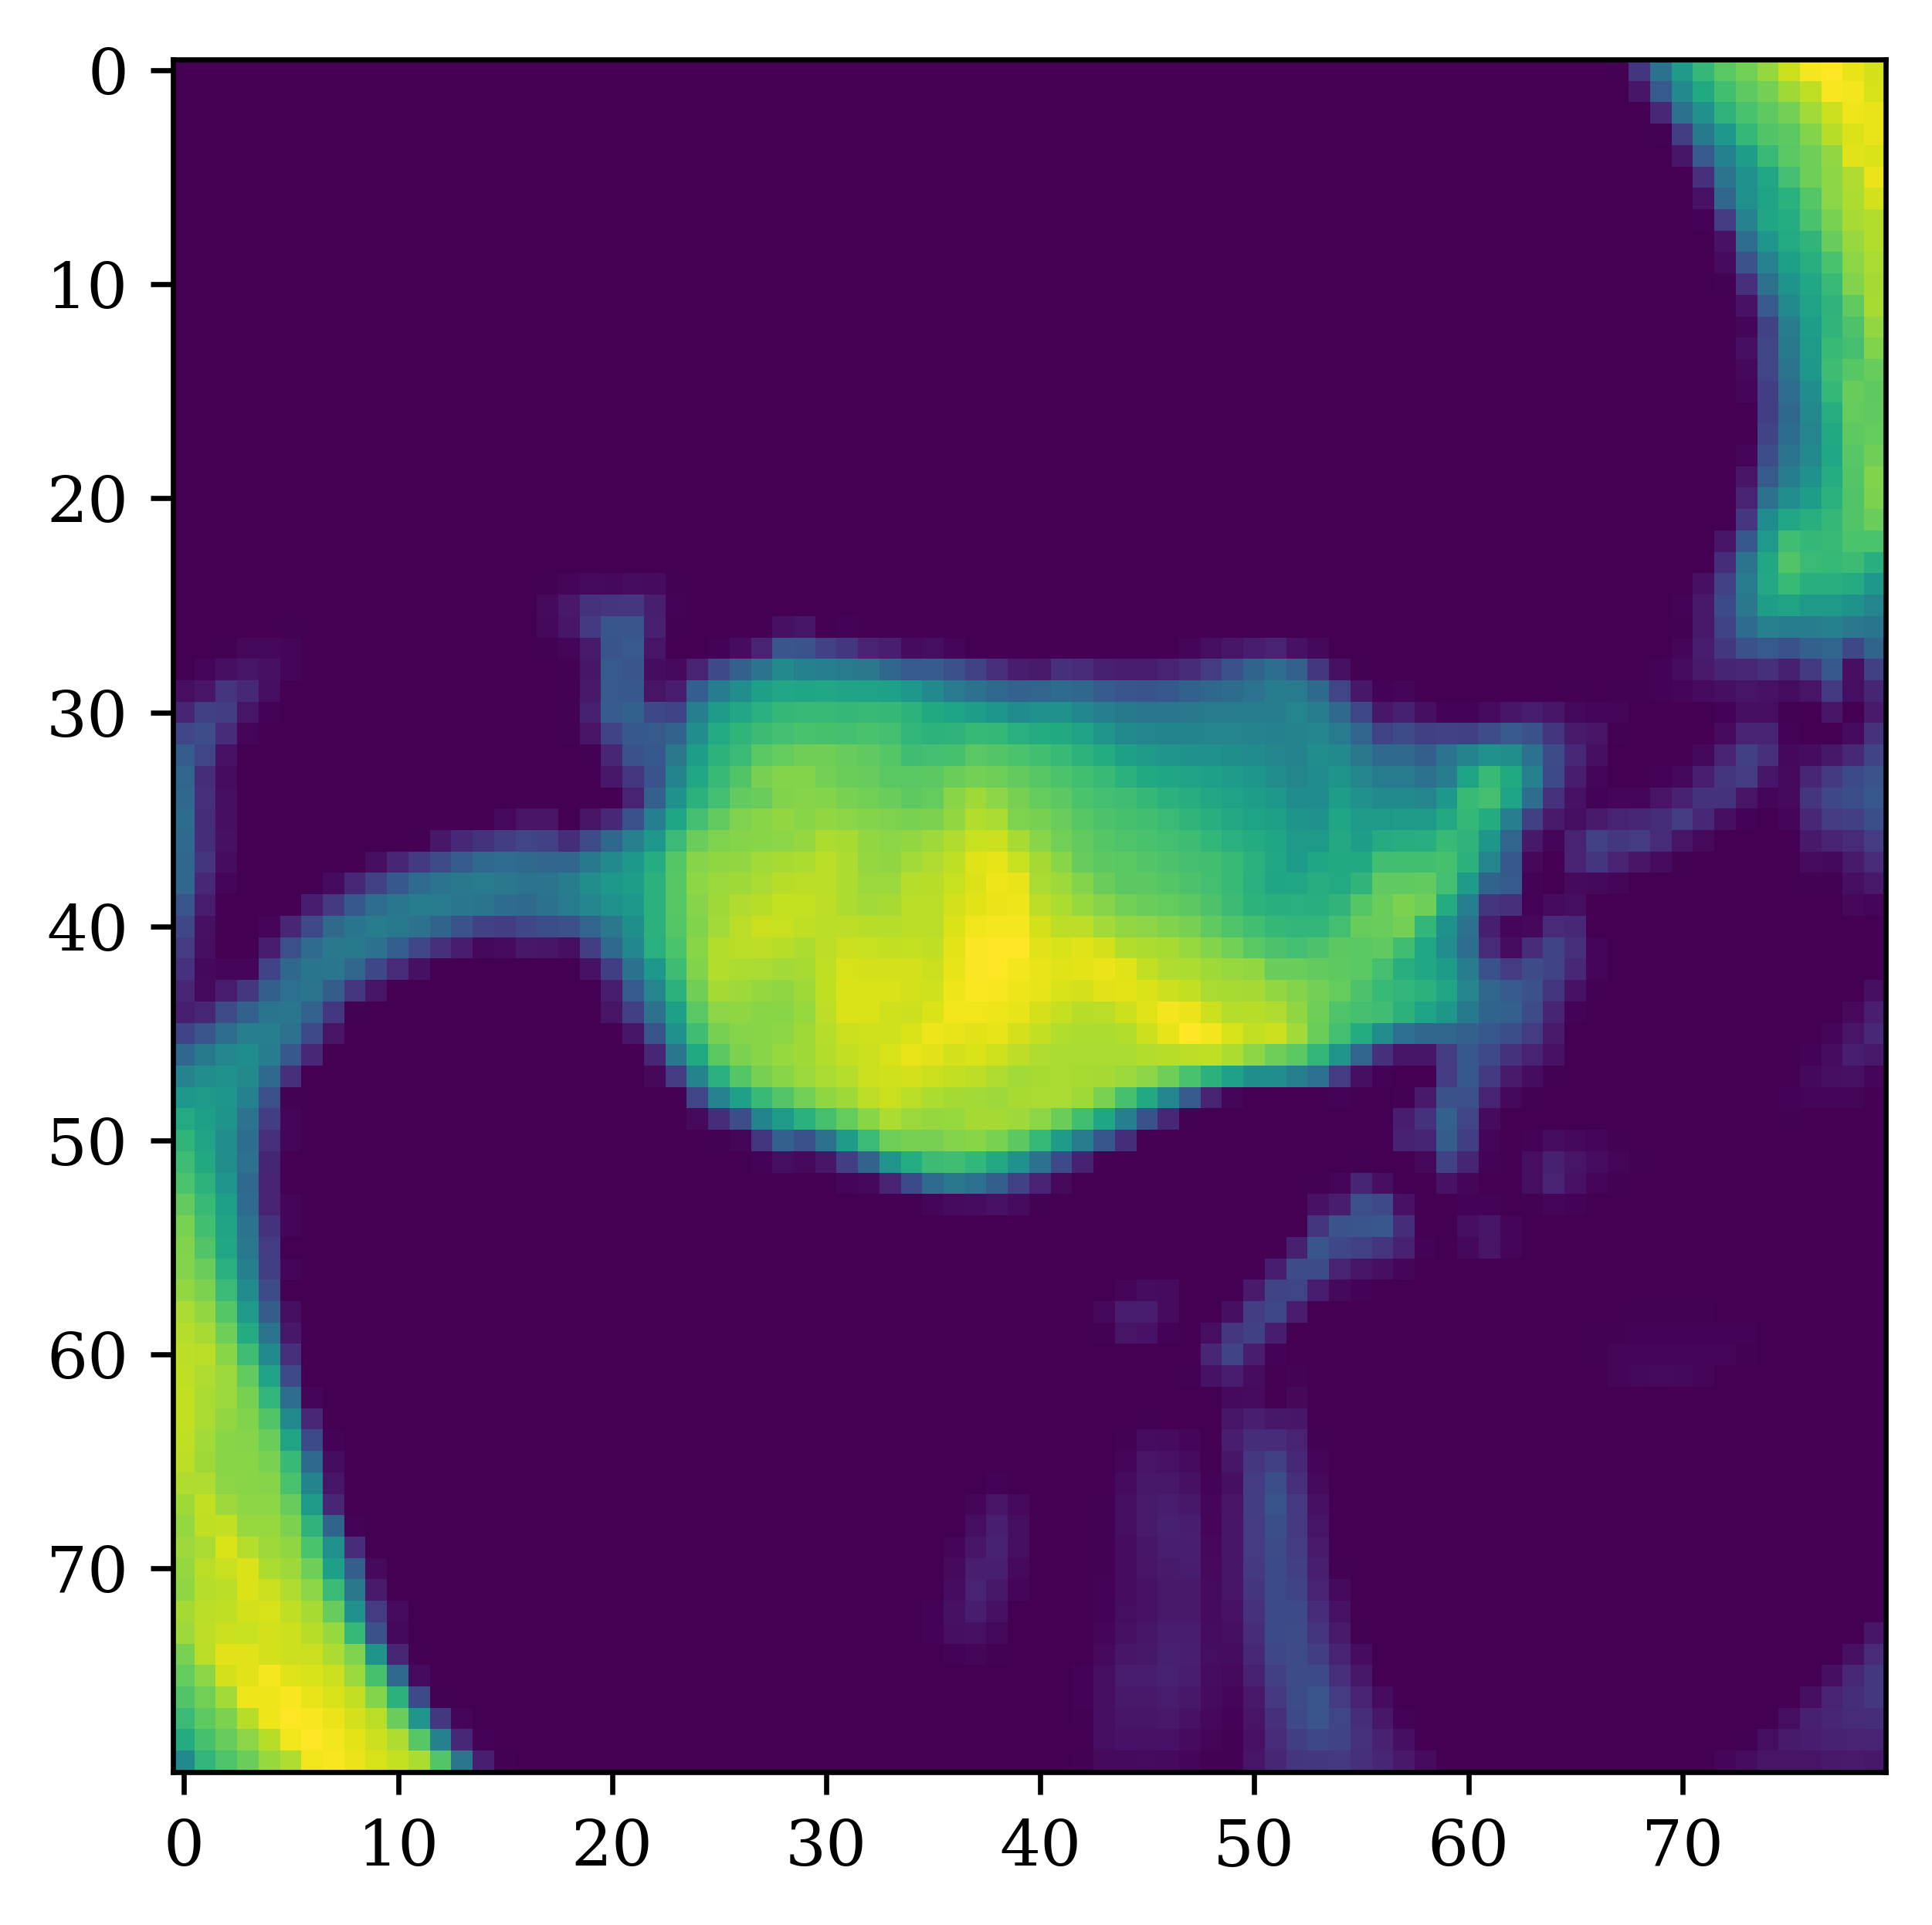

In [89]:
plt.imshow(transformed_frames[0, 0])

In [16]:
from aging.organization.paths import TrainingPaths
train_paths = TrainingPaths()
fits = dict(joblib.load(train_paths.tps_fits))
for k, v in fits.items():
    for _k, _v in v.items():
        v[_k] = _v['params']
joblib.dump(fits, train_paths.tps_params)

['/n/groups/datta/win/longtogeny/size_norm/training_data/tps_params_v2.p.gz']